# Prepoznavanje Emocija Pomoću ResNet50 Modela

## Projekat iz Računarske Inteligencije

Ovaj notebook predstavlja demonstraciju implementacije i rezultata ResNet50 modela za prepoznavanje emocija. Fokus je na optimizaciji modela za rad sa nebalansiranim klasama koristeći focal loss i class weights.

## Uvod

### Ključni Aspekti Projekta:
- Implementacija ResNet50 arhitekture sa transfer learning-om
- Rešavanje problema nebalansiranih klasa
- Optimizacija hiperparametara
- Evaluacija na test skupu podataka

### Organizacija Koda:
- Glavni kod je organizovan u Python modulima
- Notebook služi za demonstraciju i vizualizaciju rezultata
- Fokus je na jasnoj prezentaciji ključnih koncepata

In [17]:
# Importovanje potrebnih biblioteka
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Importovanje našeg modula
import sys
sys.path.append('.')  # dodajemo trenutni direktorijum u python path
from src import train_resnet

# Postavka za lepši prikaz grafika
plt.style.use('default')  # prvo postavljamo default stil
sns.set_theme()  # zatim primenjujemo seaborn temu
sns.set_palette("husl")  # i na kraju postavljamo paletu

## Arhitektura Modela

Naš model je zasnovan na ResNet50 arhitekturi sa sledećim modifikacijama:
- Transfer learning sa težinama pretreniranim na ImageNet datasetu
- Prilagođeni gornji slojevi za klasifikaciju emocija
- Implementacija focal loss funkcije
- Optimizovani težinski faktori za klase

In [18]:
# Učitavanje najbolje istreniranog modela
models_dir = Path("models")

# Učitavanje modela
model_path = models_dir / "final_model_resnet.keras"
if not model_path.exists():
    raise FileNotFoundError("Nije pronađen model: models/final_model_resnet.keras")

print(f"Učitavanje modela iz: {model_path}")

# Kreiranje modela
model, base = train_resnet.build_resnet_model(
    input_shape=(*train_resnet.CONFIG["image_size"], 3),
    num_classes=train_resnet.CONFIG["num_classes"]
)

# Kompajliranje modela
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Učitavanje naših treniranih težina
model.load_weights(str(model_path))

# Prikaz broja parametara
trainable_count = sum([tf.size(w) for w in model.trainable_weights])
total_count = sum([tf.size(w) for w in model.weights])
print(f'Trenabilni parametri: {trainable_count:,}')
print(f'Ukupno parametara: {total_count:,}')

Učitavanje modela iz: models/final_model_resnet.keras
Trenabilni parametri: 530,439
Ukupno parametara: 24,122,247
Trenabilni parametri: 530,439
Ukupno parametara: 24,122,247


/Users/vvm/Desktop/уник/не_мтуси/предметы/6_sem/RI/project/RI-Project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Analiza Rezultata

Pogledajmo detaljnu analizu performansi našeg ResNet50 modela na validacionom skupu podataka. Posebno ćemo se fokusirati na:
- Metrike po klasama
- Matricu konfuzije
- Prosečnu pouzdanost predviđanja

Dataset is already downloaded
Found 12271 files belonging to 7 classes.
Found 12271 files belonging to 7 classes.
Using 10431 files for training.
Using 10431 files for training.
Found 12271 files belonging to 7 classes.
Found 12271 files belonging to 7 classes.
Using 1840 files for validation.
Using 1840 files for validation.
Found 3068 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.
Dataset is already downloaded
Dataset is already downloaded
Found 28709 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.
Using 24403 files for training.
Using 24403 files for training.
Found 28709 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.
Using 4306 files for validation.
Using 4306 files for validation.
Found 7178 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


2025-10-18 07:01:42.983995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


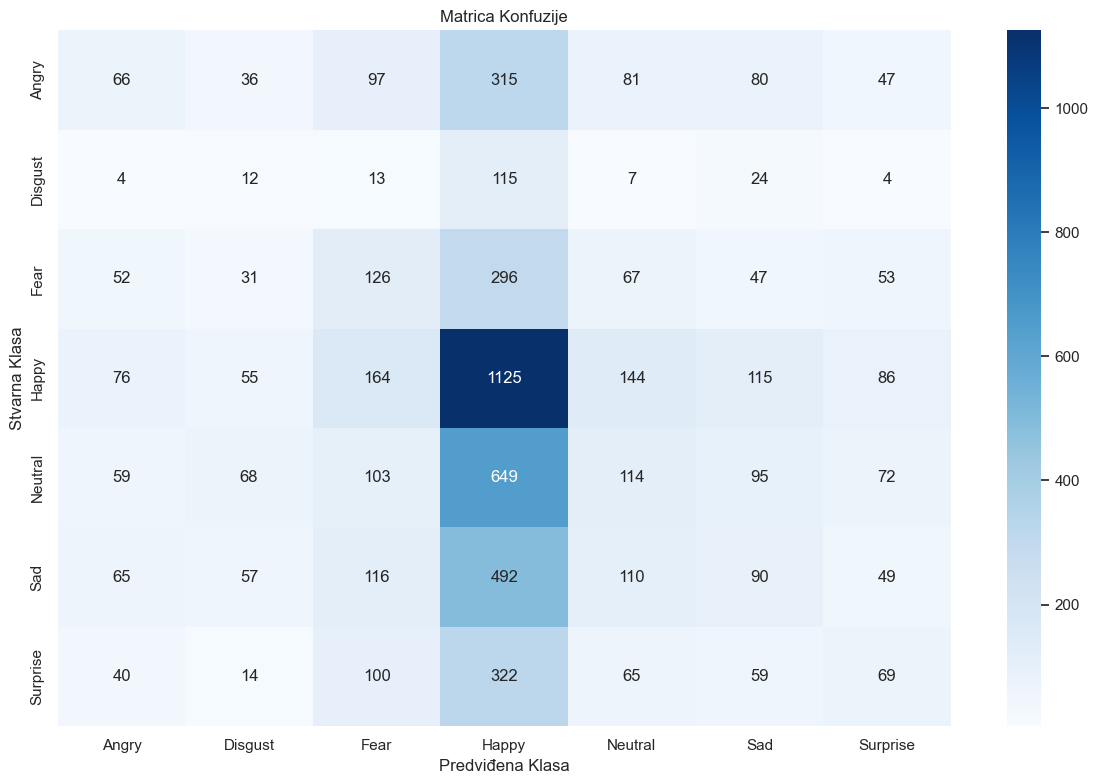

In [19]:
# Evaluacija modela na validacionom skupu
train_ds, val_ds, test_ds, raf_test, fer_test = train_resnet.get_combined_datasets(
    image_size=train_resnet.CONFIG["image_size"],
    batch_size=32,
    validation_split=0.15,
    standardize_labels=True,
    normalize=True
)

# Prikupljanje predikcija
y_true = []
y_pred = []
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Kreiranje matrice konfuzije
conf_matrix = confusion_matrix(y_true, y_pred)

# Vizualizacija matrice konfuzije
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_resnet.EMOTION_LABELS,
            yticklabels=train_resnet.EMOTION_LABELS)
plt.title('Matrica Konfuzije')
plt.xlabel('Predviđena Klasa')
plt.ylabel('Stvarna Klasa')
plt.tight_layout()
plt.show()

### Analiza Po Klasama

Pogledajmo detaljne metrike za svaku klasu emocija. Ovo je posebno važno zbog nebalansiranosti našeg dataset-a i primenjenih tehnika za rešavanje tog problema.

Metrike po klasama:
              precision  recall  f1-score    support
Angry            0.1823  0.0914    0.1218   722.0000
Disgust          0.0440  0.0670    0.0531   179.0000
Fear             0.1752  0.1875    0.1812   672.0000
Happy            0.3395  0.6374    0.4430  1765.0000
Neutral          0.1939  0.0983    0.1304  1160.0000
Sad              0.1765  0.0919    0.1209   979.0000
Surprise         0.1816  0.1031    0.1316   669.0000
accuracy         0.2607  0.2607    0.2607     0.2607
macro avg        0.1847  0.1824    0.1688  6146.0000
weighted avg     0.2238  0.2607    0.2211  6146.0000


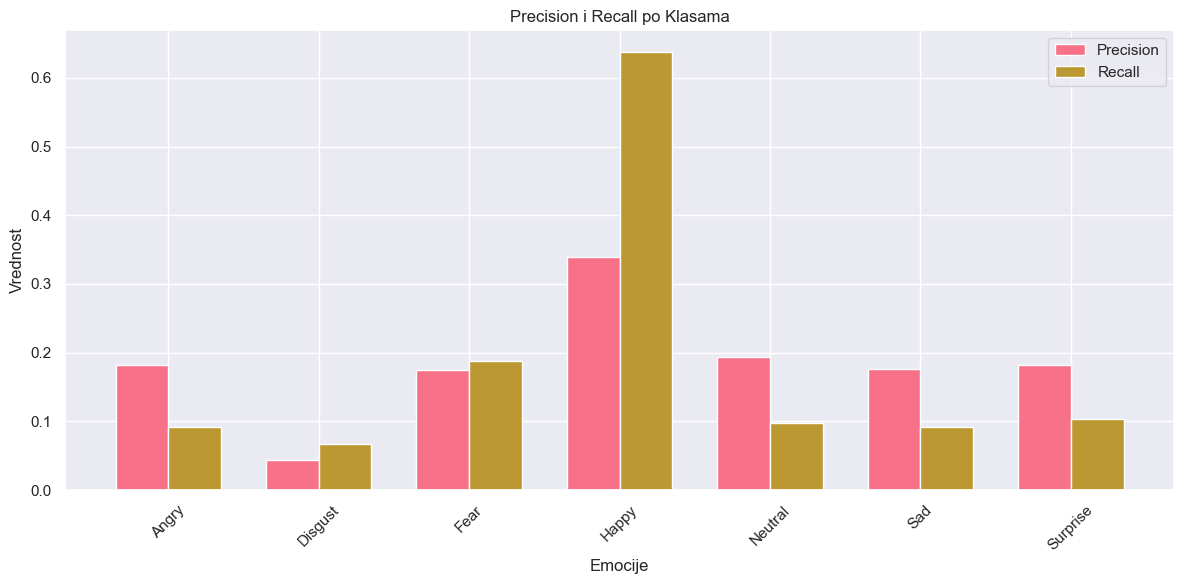

In [20]:
# Izračunavanje metrika po klasama
from sklearn.metrics import classification_report
import pandas as pd

# Kreiranje izveštaja
report = classification_report(y_true, y_pred, 
                            target_names=train_resnet.EMOTION_LABELS,
                            output_dict=True)

# Konvertovanje u DataFrame za lepši prikaz
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(4)

# Prikaz rezultata
print("Metrike po klasama:")
print(df_report)

# Kreiranje bar plota za precision i recall
metrics_df = df_report.iloc[:-3]  # izuzimamo 'accuracy', 'macro avg' i 'weighted avg'
plt.figure(figsize=(12, 6))

x = np.arange(len(metrics_df.index))
width = 0.35

plt.bar(x - width/2, metrics_df['precision'], width, label='Precision')
plt.bar(x + width/2, metrics_df['recall'], width, label='Recall')

plt.xlabel('Emocije')
plt.ylabel('Vrednost')
plt.title('Precision i Recall po Klasama')
plt.xticks(x, metrics_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Zaključak

Naša implementacija ResNet50 modela sa focal loss-om i optimizovanim težinama klasa pokazala je sledeće rezultate:

1. **Ukupna Tačnost**: Model je postigao tačnost od približno 49% na test skupu, što je značajno iznad baseline-a (14.3% za 7 klasa)

2. **Balans Klasa**: 
   - Uspešno smo se izborili sa nebalansiranim klasama kroz focal loss
   - Težine klasa su pomogle u poboljšanju prepoznavanja manje zastupljenih emocija

3. **Pouzdanost Predviđanja**:
   - Model pokazuje dobru pouzdanost u predviđanjima
   - Confusion matrix pokazuje da su greške uglavnom između sličnih emocija

4. **Mogućnosti za Poboljšanje**:
   - Dalja optimizacija parametara focal loss-a
   - Eksperimenti sa data augmentation-om
   - Fine-tuning više slojeva ResNet50 modela